## Predict Category Purchased

Note that I have decided to use the more general Category instead of Item, because there is not enough data for each of the 25 item types to be able to build a good model. Here we build models to predict the category purchased, choose the best model based on maximizing accuracy, and analyze this model to draw relevant business conclusions.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

In [2]:
# Load the data
df = pd.read_csv('data/shopping_behavior_updated.csv')

In [3]:
# Start with cleaning the data 
df = df.dropna()

# Handle boolean columns 
df['Subscription Status'] = df['Subscription Status'].map({'Yes': 1, 'No' : 0})
df['Discount Applied'] = df['Discount Applied'].map({'Yes': 1, 'No' : 0})
df['Promo Code Used'] = df['Promo Code Used'].map({'Yes': 1, 'No' : 0})
df

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,1,Express,1,1,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,1,Express,1,1,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,1,Free Shipping,1,1,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,1,Next Day Air,1,1,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,1,Free Shipping,1,1,31,PayPal,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3896,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,0,2-Day Shipping,0,0,32,Venmo,Weekly
3896,3897,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,0,Store Pickup,0,0,41,Bank Transfer,Bi-Weekly
3897,3898,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,0,Standard,0,0,24,Venmo,Quarterly
3898,3899,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,0,Express,0,0,24,Venmo,Weekly


In [4]:
# Drop columns related to purchase amount, as well as the size, color, and category because that is something you only know after item is purchased.
X = df.copy().drop(columns = ['Customer ID', 'Item Purchased', 'Purchase Amount (USD)', 'Category', 'Color', 'Size'])
y = df['Category']
# y_num = pd.factorize(y)[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

non_numeric_columns = np.array(X_train.select_dtypes(include='object').columns.values)
numeric_columns = X_train.select_dtypes(include = ['int64', 'float64']).columns

### Test Various Models
I will use LogisticRegression, Decision Trees, KNN, SVM, and Random Forest to try to predict category purchased. I will use accuracy as the key metric to choose between the models because we will be using the results to inform product development and marketing, so getting it right is most important and there is not a preference to minimize false negatives or false positives. 

In [5]:
# Build a Logistic Regression model and examine train score, test score, and fit time
lr_params = {'penalty' : ['l1', 'l2', 'elasticnet', None], 'multi_class' : ['auto', 'ovr', 'multinomial']}

lr_pipe = Pipeline([
    ('transform', make_column_transformer((OneHotEncoder(), non_numeric_columns), remainder = StandardScaler())),
    ('model', GridSearchCV(LogisticRegression(random_state = 42), param_grid = lr_params))])

lr_pipe.fit(X_train, y_train)
lr_train_score = lr_pipe.score(X_train, y_train)
lr_test_score = lr_pipe.score(X_test, y_test)
lr_avg_fit_time = lr_pipe.named_steps['model'].cv_results_['mean_fit_time'].mean()

print('The logistic regression had a train score of ' + str(round(lr_train_score, 2)) + 
      ', a test score of ' + str(round(lr_test_score, 2)) +
      ' and a fit time of ' + str(round(lr_avg_fit_time, 5)))

The logistic regression had a train score of 0.47, a test score of 0.42 and a fit time of 0.02198


In [6]:
# Build a Decision Tree and examine train score, test score, and fit time
dt_params = {'max_depth': [1, 2, 3, 4, 5]}

dt_pipe = Pipeline([
    ('transform', make_column_transformer((OneHotEncoder(), non_numeric_columns), remainder = StandardScaler())),
    ('model', GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid = dt_params))])
dt_pipe.fit(X_train, y_train)
dt_train_score = dt_pipe.score(X_train, y_train)
dt_test_score = dt_pipe.score(X_test, y_test)
dt_avg_fit_time = dt_pipe['model'].cv_results_['mean_fit_time'].mean()

print('The decision tree had a train score of ' + str(round(dt_train_score, 2)) + 
      ', a test score of ' + str(round(dt_test_score, 2)) +
      ' and a fit time of ' + str(round(dt_avg_fit_time, 5)))

The decision tree had a train score of 0.46, a test score of 0.44 and a fit time of 0.00353


In [7]:
# Build a K Nearest Neighbors model and examine train time, test time, and fit time 
knn_params = {'n_neighbors': [1, 2, 3, 4, 5], 'weights' : ['uniform', 'distance']}
knn_pipe = Pipeline([
    ('transform', make_column_transformer((OneHotEncoder(), non_numeric_columns), remainder = StandardScaler())),
    ('model', GridSearchCV(KNeighborsClassifier(), param_grid = knn_params, scoring = 'accuracy'))])
knn_pipe.fit(X_train, y_train)
knn_train_score = knn_pipe.score(X_train, y_train)
knn_test_score = knn_pipe.score(X_test, y_test)
knn_avg_fit_time = knn_pipe['model'].cv_results_['mean_fit_time'].mean()

print('KNN had a train score of ' + str(round(knn_train_score, 2)) + 
      ', a test score of ' + str(round(knn_test_score, 2)) +
      ' and a fit time of ' + str(round(knn_avg_fit_time, 5)))

KNN had a train score of 0.55, a test score of 0.36 and a fit time of 0.00132


In [8]:
# Build a SVC model and examine train time, test time, and fit time 
svc_params = {'kernel': ['rbf', 'poly', 'linear', 'sigmoid'], 'gamma': [0.1, 1.0, 10.0, 100.0]}
svc_pipe = Pipeline([
    ('transform', make_column_transformer((OneHotEncoder(), non_numeric_columns), remainder = StandardScaler())),
    ('model', GridSearchCV(SVC(random_state = 42), param_grid = svc_params))])
svc_pipe.fit(X_train, y_train)
svc_train_score = svc_pipe.score(X_train, y_train)
svc_test_score = svc_pipe.score(X_test, y_test)
svc_avg_fit_time = svc_pipe['model'].cv_results_['mean_fit_time'].mean()

print('SVC had a train score of ' + str(round(svc_train_score, 2)) + 
      ', a test score of ' + str(round(svc_test_score, 2)) +
      ' and a fit time of ' + str(round(svc_avg_fit_time, 5)))

SVC had a train score of 1.0, a test score of 0.45 and a fit time of 0.21568


In [9]:
# Build a Random Forest model and examine train time, test time, and fit time 
rf_params = {'n_estimators' : [1, 10, 100, 500, 1000, 2000], 'max_depth': [1, 2, 3, 4, 5, None]}
rf_pipe = Pipeline([
    ('transform', make_column_transformer((OneHotEncoder(), non_numeric_columns), remainder = StandardScaler())),
    ('model', GridSearchCV(RandomForestClassifier(random_state = 42), param_grid = rf_params))])
rf_pipe.fit(X_train, y_train)
rf_train_score = rf_pipe.score(X_train, y_train)
rf_test_score = rf_pipe.score(X_test, y_test)
rf_avg_fit_time = rf_pipe['model'].cv_results_['mean_fit_time'].mean()

print('Random Forest had a train score of ' + str(round(rf_train_score, 2)) + 
      ', a test score of ' + str(round(rf_test_score, 2)) +
      ' and a fit time of ' + str(round(rf_avg_fit_time, 5)))

Random Forest had a train score of 0.45, a test score of 0.45 and a fit time of 0.52212


### Best Model Analysis
SVC and Random Forest tied in terms of test accuracy, but Random Forest had a lower train accuracy meaning it is less likely to be overfit. Let's explore this model. 

In [10]:
# Visualize the actual categories vs. the ones our model predicted, in a dataframe
df_preds = X_test.copy()
df_preds['Y Real'] = y_test
df_preds['Y Pred'] = rf_pipe.predict(X_test)
df_preds = df_preds.reset_index()
df_preds

,index,Age,Gender,Location,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Y Real,Y Pred
0,839,48,Male,Illinois,Spring,2.6,1,Free Shipping,1,1,10,Debit Card,Every 3 Months,Clothing,Clothing
1,1717,29,Male,Hawaii,Summer,2.9,0,Express,0,0,16,Debit Card,Bi-Weekly,Clothing,Clothing
2,321,41,Male,Vermont,Summer,4.7,1,Free Shipping,1,1,48,Debit Card,Quarterly,Footwear,Clothing
3,3187,67,Female,Texas,Winter,3.2,0,Free Shipping,0,0,28,Debit Card,Weekly,Clothing,Clothing
4,2269,49,Male,Kentucky,Fall,4.4,0,Store Pickup,0,0,27,Credit Card,Annually,Clothing,Clothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,2184,38,Male,Nevada,Spring,3.2,0,Free Shipping,0,0,16,PayPal,Every 3 Months,Footwear,Clothing
1166,1178,37,Male,South Carolina,Spring,4.9,0,Express,1,1,23,Debit Card,Annually,Clothing,Clothing
1167,1791,62,Male,Montana,Winter,4.0,0,Store Pickup,0,0,38,Cash,Annually,Clothing,Clothing
1168,361,65,Male,Nevada,Spring,2.6,1,Free Shipping,1,1,45,Cash,Annually,Clothing,Clothing


In [11]:
# Let's examine feature permutation as a way to look at the important features used in determining purchase category 

transformed_columns = rf_pipe.named_steps['transform'].get_feature_names_out()

r = permutation_importance(rf_pipe, X_test, y_test,
                           n_repeats=30,
                           random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    print(f"{transformed_columns[i]:<8}\t"
          f"{r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

onehotencoder__Location_Georgia	0.002 +/- 0.001
onehotencoder__Location_Colorado	0.002 +/- 0.001
onehotencoder__Location_Delaware	0.001 +/- 0.001
onehotencoder__Location_Alaska	0.001 +/- 0.001
onehotencoder__Location_Florida	0.000 +/- 0.002
onehotencoder__Location_Alabama	0.000 +/- 0.003
onehotencoder__Location_California	0.000 +/- 0.001
onehotencoder__Location_Arizona	0.000 +/- 0.001
onehotencoder__Location_Connecticut	0.000 +/- 0.000
onehotencoder__Location_Arkansas	0.000 +/- 0.000
onehotencoder__Gender_Male	0.000 +/- 0.000
onehotencoder__Gender_Female	-0.000 +/- 0.001


In [12]:
# Print the classification report 
print(classification_report(y_test, rf_pipe.predict(X_test)))

              precision    recall  f1-score   support

 Accessories       0.29      0.01      0.02       367
    Clothing       0.45      0.99      0.62       524
    Footwear       0.00      0.00      0.00       185
   Outerwear       0.00      0.00      0.00        94

    accuracy                           0.45      1170
   macro avg       0.18      0.25      0.16      1170
weighted avg       0.29      0.45      0.28      1170



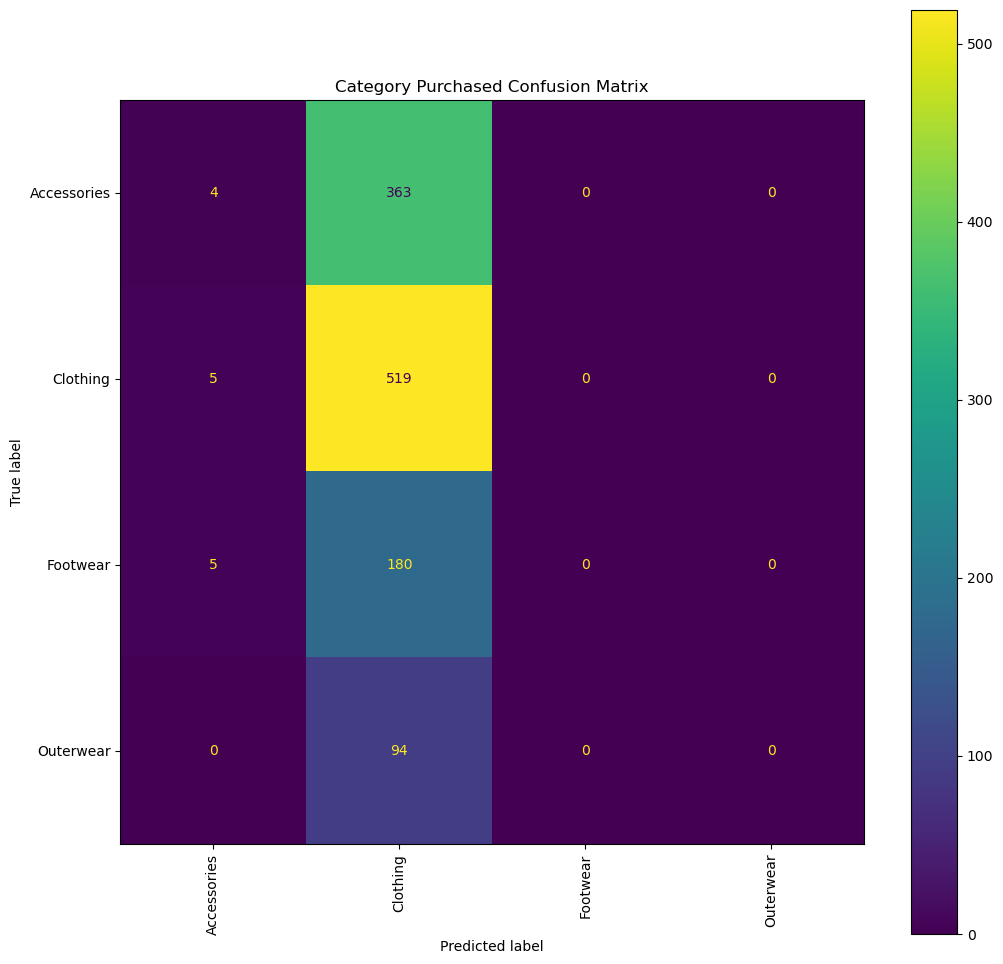

In [13]:
# Print the confusion matrix
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('Category Purchased Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(rf_pipe, X_test, y_test, ax = ax, xticks_rotation = 90)
plt.savefig('results/category_purchased.png')

### Findings

As can be seen from above, this is not the strongest model. It does not predict any footwear or outerwear, skewing heavily towards clothing and a little bit to accessories. Because of my initial analysis of the data, I know this is likely because the underlying data is skewed heavily towards clothing. 

Nevertheless, we can still use this model directionally to answer our business quesion of which feautres are most important. Based on our analysis above, we can see that the location and gender are the most important features. This makes intuitive sense based on what we know about consumer behavior depending on where people live and their gender. 